In [4]:
#import usual packages for data manipulation
import pandas as pd
import numpy as np

#import usual packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import datetime to get the current date
import datetime as dt

#from alpha vantage, import the TimeSeries class
from alpha_vantage.timeseries import TimeSeries

import json

#set the style of the plots
plt.style.use('seaborn-v0_8-whitegrid')

In [5]:
#set the API key
my_key = 'DJ3QKKTFZ5J298QY'

#initialize the TimeSeries class
ts = TimeSeries(key=my_key, output_format='pandas')

In [3]:
#choose a ticker
ticker = 'AMZN'

In [6]:
stock_data, stock_meta_data = ts.get_daily(ticker,outputsize='full')

In [19]:
stock_data.index

DatetimeIndex(['2024-08-16', '2024-08-15', '2024-08-14', '2024-08-13',
               '2024-08-12', '2024-08-09', '2024-08-08', '2024-08-07',
               '2024-08-06', '2024-08-05',
               ...
               '1999-11-12', '1999-11-11', '1999-11-10', '1999-11-09',
               '1999-11-08', '1999-11-05', '1999-11-04', '1999-11-03',
               '1999-11-02', '1999-11-01'],
              dtype='datetime64[ns]', name='date', length=6238, freq=None)

In [20]:
df = stock_data.copy()
df.columns = ['open','high','low','close','volume']
df.sort_index(inplace=True)
df = df[df.index.year >= 2014]
# df.to_csv(f'../data/{ticker}_stock.csv')

In [1]:
def wtd_std(vals,wts):
    wtd_mean = np.average(vals,weights=wts)
    vals_demeaned = vals - wtd_mean
    wtd_var = np.average(vals_demeaned**2,weights=wts)
    return np.sqrt(wtd_var)

def get_wtd_std(vals,wts,window):
    ser = np.zeros(len(df))
    for i in range(len(df)-1 , 0, -1):
        if i < window:
            ser[i] = np.nan
        else:
            ser[i] = wtd_std(vals.iloc[i-window+1:i+1],wts.iloc[i-window+1:i+1])
    return ser

In [5]:
wtd_std([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],[0.2,1,0.5,0.2,22,0.5,0.2,0.1,0.5,3])

1.8201129708892951

In [22]:
#window sizes for moving avgs and volume-weighted moving avgs
windows = [5, 11, 21, 63, 125, 251]
#calculate past moving averages, standard dev's, volume-weighted moving averages, and standard dev's of volume-weighted moving averages
for w in windows:
    df[f'ma_{w}'] = df['close'].rolling(w).mean()
    df[f'std_{w}'] = df['close'].rolling(w).std()
    #compute the w-day volume weights
    df[f'wts_{w}'] = df['volume'] / df['volume'].rolling(w).sum()
    #compute VWAP by dotting the w-day close price with the w-day volume weights
    df[f'vwap_{w}'] = (df['close'] * df[f'wts_{w}']).rolling(w).sum()
    #compute the weighted standard deviation of the volume-weighted moving averages
    df[f'vwstd_{w}'] = get_wtd_std(vals = df[f'close'],
                                   wts = df[f'wts_{w}'],
                                   window = w)
    #drop the volume weights
    df.drop(columns=f'wts_{w}',inplace=True)
    # add rolling bollinger bands for windows w in [5,11,21,63,125,251]
    # bollinger bands are defined as the moving average plus/minus 2 times the moving standard deviation
    # store the upper and lower bands in columns f'bbu_{w}' and f'bbl_{w}'
    # do the same for the vol-weighted averages and standard deviations
    df[f'bbu_{w}'] = df[f'ma_{w}'] + 2 * df[f'std_{w}']
    df[f'bbl_{w}'] = df[f'ma_{w}'] - 2 * df[f'std_{w}']
    df[f'vwbbu_{w}'] = df[f'vwap_{w}'] + 2 * df[f'vwstd_{w}']
    df[f'vwbbl_{w}'] = df[f'vwap_{w}'] - 2 * df[f'vwstd_{w}']
#drop NaN's
# df.dropna(inplace=True)
#save to csv in same folder as the original data, with title f'{ticker}_stock_features.csv'
df.to_csv(f'../data/{ticker}_stock_features.csv')
    

In [23]:
df

,open,high,low,close,volume,ma_5,std_5,vwap_5,vwstd_5,bbu_5,...,vwbbu_125,vwbbl_125,ma_251,std_251,vwap_251,vwstd_251,bbu_251,bbl_251,vwbbu_251,vwbbl_251
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,398.80,399.36,394.0200,397.97,2137800.0,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2014-01-03,398.29,402.71,396.2200,396.44,2210200.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,395.85,397.00,388.4200,393.63,3170600.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,395.04,398.47,394.2900,398.03,1916000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,398.47,403.00,396.0400,401.92,2316500.0,397.598,3.003776,NaN,NaN,403.605552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,168.14,168.55,166.1101,166.80,30072788.0,164.848,2.341254,108.755133,2.138340,169.530508,...,187.128198,151.998663,162.197191,21.872341,133.967014,21.861822,205.941873,118.452509,177.690658,90.243370
2024-08-13,167.81,171.04,167.1000,170.23,39237915.0,166.508,2.673905,117.890393,2.490407,171.855811,...,186.847841,151.816602,162.315359,21.835120,134.146330,21.821754,205.985598,118.645119,177.789839,90.502822
2024-08-14,172.11,172.28,168.8600,170.10,28843804.0,167.974,2.048360,125.740928,1.847642,172.070721,...,186.634820,151.587327,162.444562,21.784593,134.217491,21.781785,206.013749,118.875375,177.781061,90.653921


In [24]:
# we want to plot the stock data 'close' price for the year 2022
# make 10 subplots (5 rows and 2 columns)
# the rows correspond to w in windows, the columns correspond to the moving average and the volume-weighted moving average
# on each subplot, plot the close price in black, the moving avg (or vwap) in blue, and shade the region between the upper and lower bollinger bands in light blue
# label the close price and the moving average (or vwap) with the corresponding window size, e.g. '5-day MA' or '11-day VWAP'
# set the title of each subplot to the corresponding window size, e.g. '5-day averages'
# set the title of the entire plot to f'{ticker} close price for 2022'
def plot_bollinger(temp,ticker,windows):
    fig, axs = plt.subplots(len(windows),2,figsize=(20,15),sharex=True)
    for i, w in enumerate(windows):
        axs[i,0].plot(temp.index,temp['close'],color='black',label='close',linewidth=0.5)
        axs[i,0].plot(temp.index,temp[f'ma_{w}'],color='blue',label=f'{w}-day MA',linewidth=0.5)
        axs[i,0].fill_between(temp.index,temp[f'bbu_{w}'],temp[f'bbl_{w}'],color='lightblue')
        # axs[i,0].set_title(f'{w}-day averages')
        axs[i,0].legend()
        axs[i,1].plot(temp.index,temp['close'],color='black',label='close',linewidth=0.5)
        axs[i,1].plot(temp.index,temp[f'vwap_{w}'],color='red',label=f'{w}-day VWAP',linewidth=0.5)
        axs[i,1].fill_between(temp.index,temp[f'vwbbu_{w}'],temp[f'vwbbl_{w}'],color='pink')
        # axs[i,1].set_title(f'{w}-day volume-weighted averages')
        axs[i,1].legend()
    fig.suptitle(f'{ticker} close price for 2022')
    plt.tight_layout()
    plt.show()

In [115]:
stocks = {t: pd.read_csv(f'../data/{t}_stock_features.csv',index_col='date',parse_dates=True,dtype=float) for t in ['AAPL','AMZN']}
financials = {t: pd.read_csv(f'../data/{t}_financials.csv',index_col='date',parse_dates=True) for t in ['AAPL','AMZN']}
for t in ['AAPL','AMZN']:
    df_fin = financials[t]
    for col in df_fin.columns.to_list(): 
        if col != 'reportedDate':
            df_fin[col] = pd.to_numeric(df_fin[col],errors='coerce')

FileNotFoundError: [Errno 2] No such file or directory: '../data/AAPL_financials.csv'

In [65]:
df = stocks['AMZN']
df.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08',
               '2024-08-09', '2024-08-12', '2024-08-13', '2024-08-14',
               '2024-08-15', '2024-08-16'],
              dtype='datetime64[ns]', name='date', length=2674, freq=None)

[]

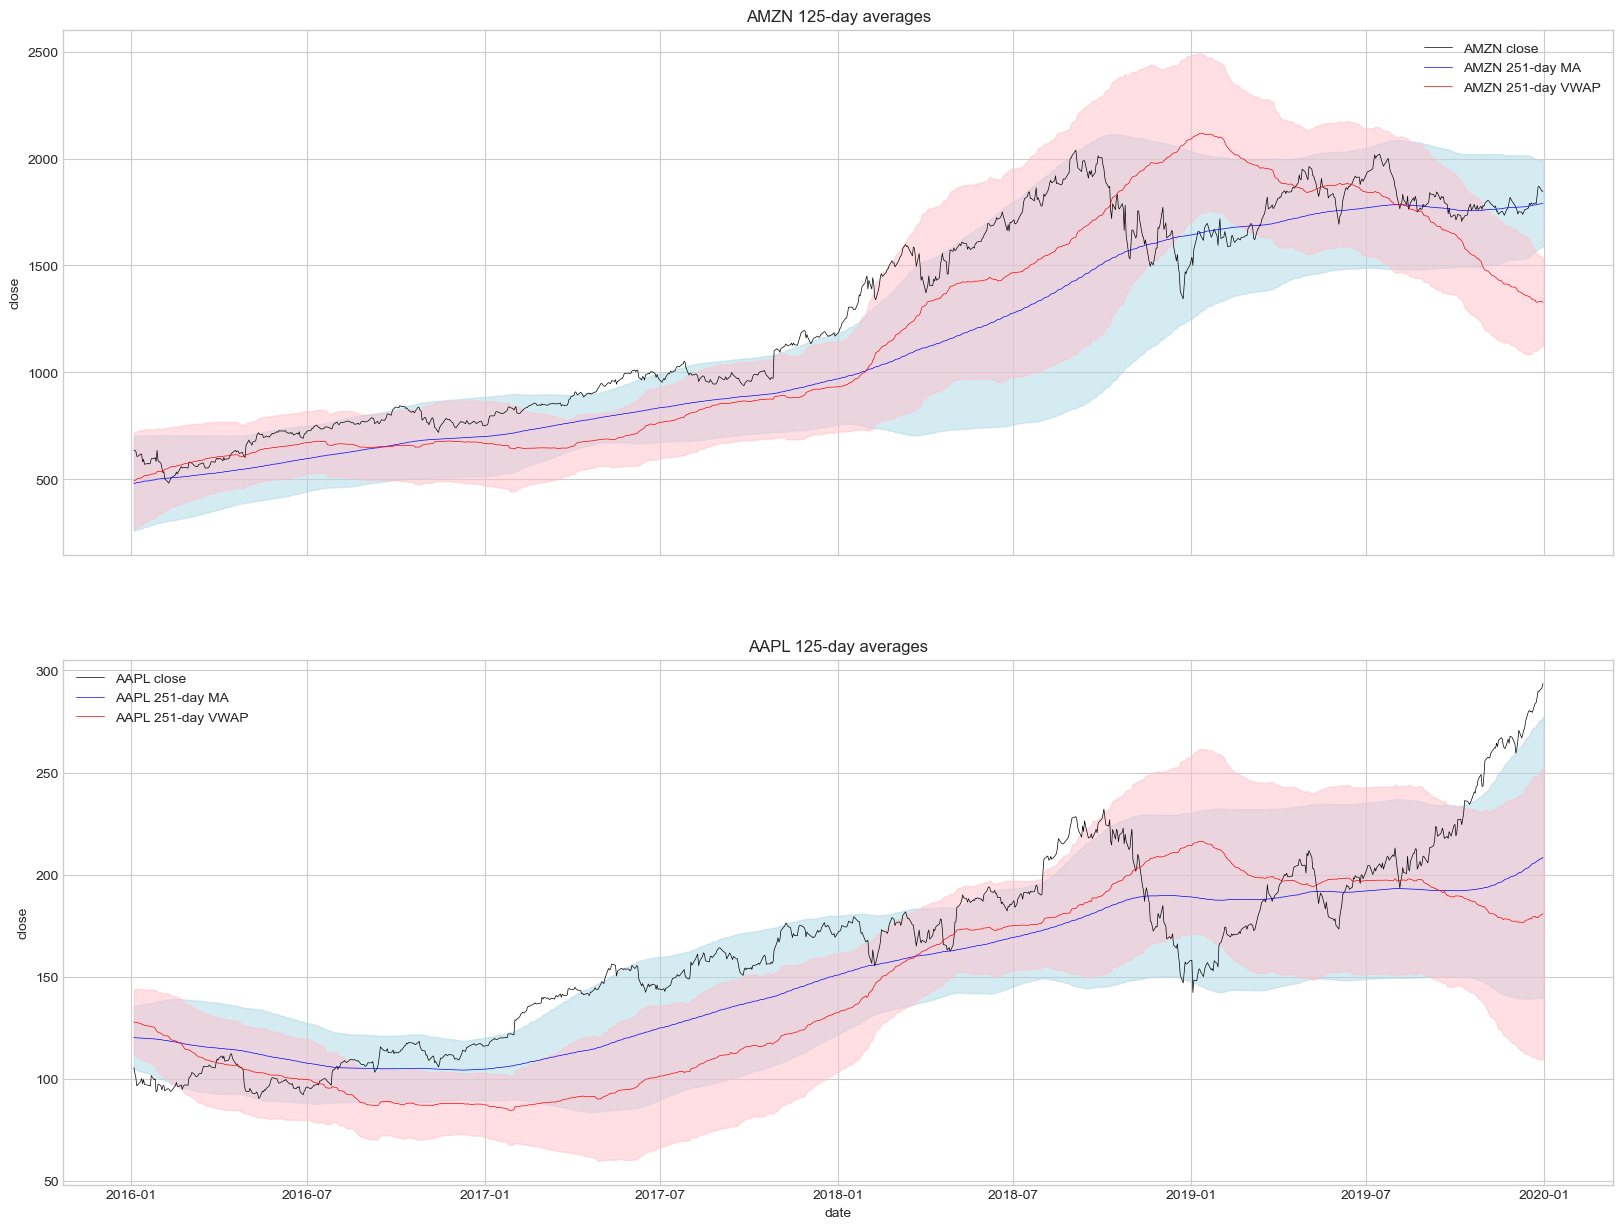

In [73]:
fig, axs = plt.subplots(2,1,figsize=(20,15),sharex=True)
for i, t in enumerate(['AMZN','AAPL']):
    df = stocks[t]
    df = df[df.index.year.isin(list(range(2016,2020)))]
    sns.lineplot(x=df.index, y=df['close'], color='black', label=f'{t} close', linewidth=0.5, ax=axs[i])
    sns.lineplot(x=df.index, y=df['ma_251'], color='blue', label=f'{t} 251-day MA', linewidth=0.5, ax=axs[i])
    sns.lineplot(x=df.index, y=df['vwap_251'], color='red',label=f'{t} 251-day VWAP',linewidth=0.5, ax=axs[i])
    axs[i].fill_between(x=df.index, y1=df['bbu_251'], y2=df['bbl_251'], color='lightblue', alpha=0.5)
    axs[i].fill_between(x=df.index, y1=df['vwbbu_251'], y2=df['vwbbl_251'], color='pink', alpha=0.5)
    # axs[i].fill_between(stocks[t]['bbu_21'],stocks[t]['bbl_21'],color='lightblue',alpha=0.5)
    # axs[1].fill_between(stocks[t]['vwbbu_21'],stocks[t]['vwbbl_21'],color='pink',alpha=0.5)
    axs[i].set_title(f'{t} 125-day averages')
    axs[i].legend()
plt.plot()

[]

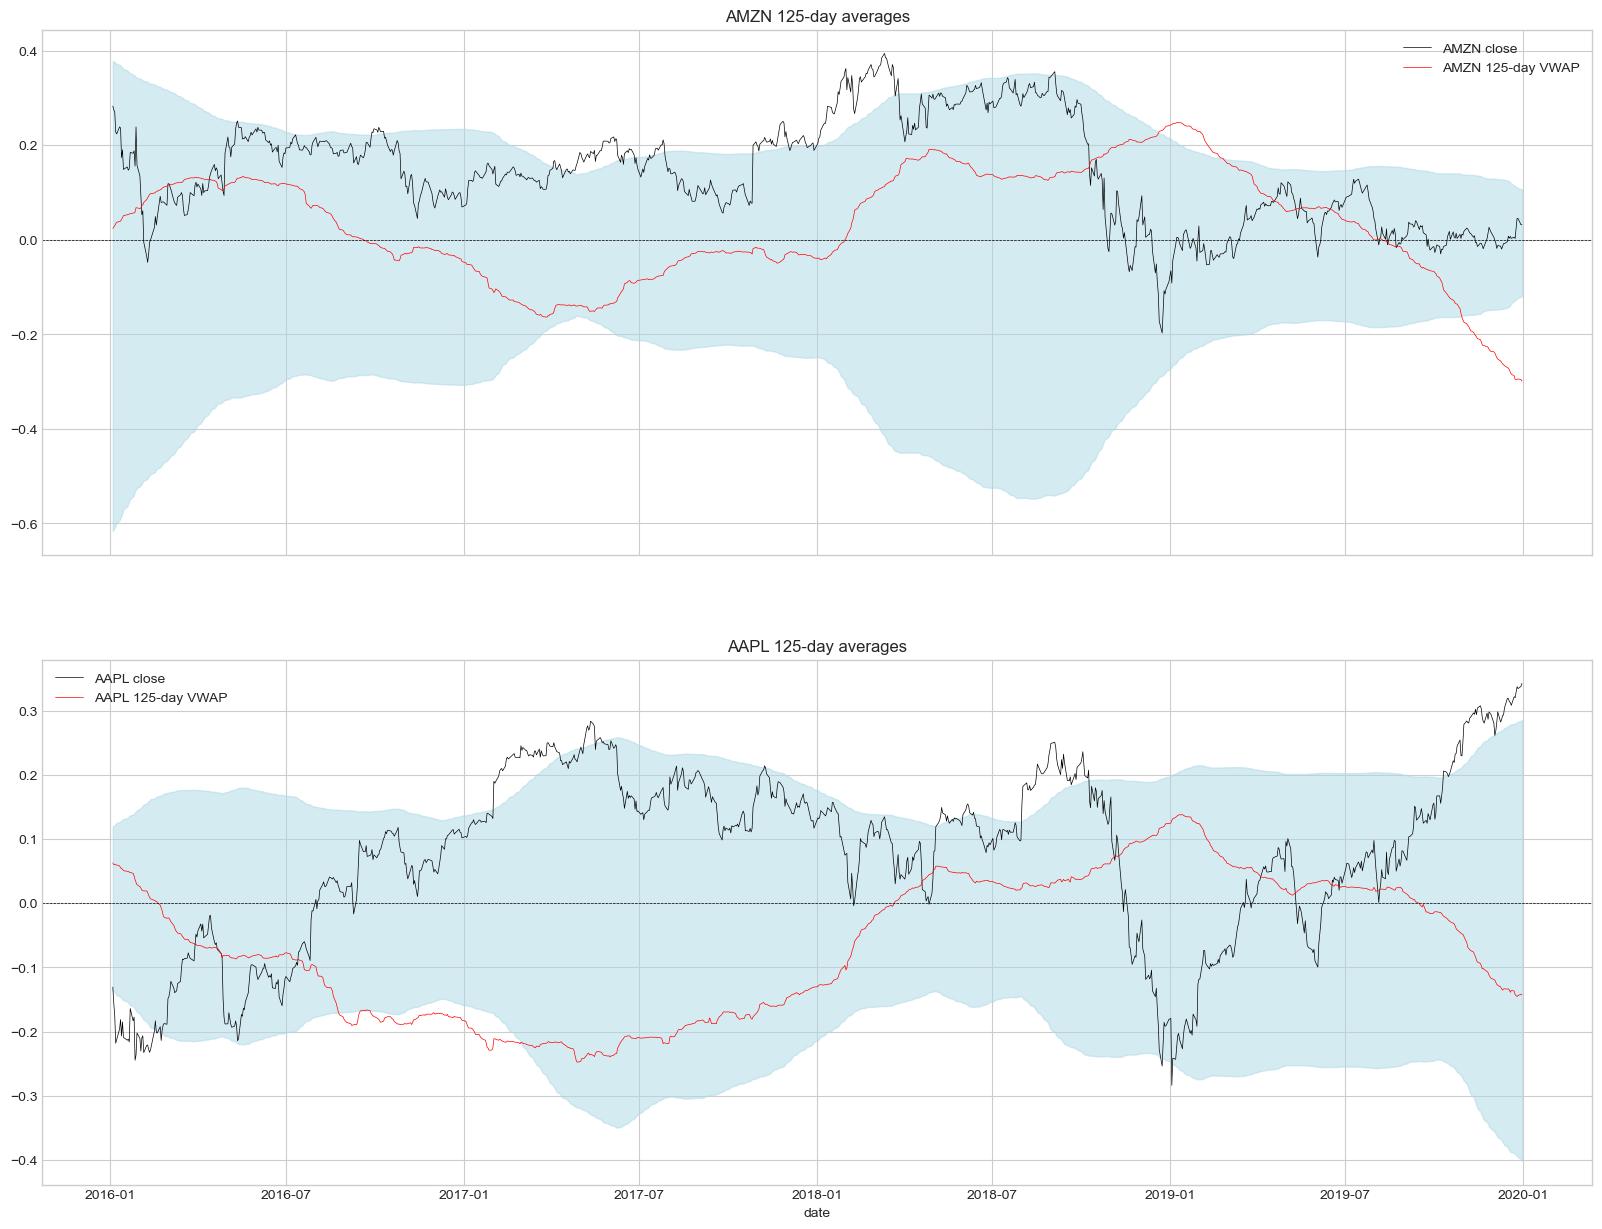

In [84]:
fig, axs = plt.subplots(2,1,figsize=(20,15),sharex=True)
for i, t in enumerate(['AMZN','AAPL']):
    df = stocks[t]
    df = df[df.index.year.isin([2016,2017,2018,2019,2019])]
    sns.lineplot(np.log(df['close']) - np.log(df['ma_251']),color='black',label=f'{t} close',linewidth=0.5,ax=axs[i])
    # sns.lineplot(np.log(df['ma_251']),color='blue',label=f'{t} 125-day MA',linewidth=0.5,ax=axs[i])
    sns.lineplot(np.log(df['vwap_251']) - np.log(df['ma_251']),color='red',label=f'{t} 125-day VWAP',linewidth=0.5,ax=axs[i])
    axs[i].axhline(0,linestyle='--',linewidth=0.5,color='black')
    axs[i].fill_between(df.index,y1= np.log(df['bbu_251']) - np.log(df['ma_251']), y2 = np.log(df['bbl_251']) - np.log(df['ma_251']), color='lightblue', alpha=0.5)
    # axs[i].fill_between(stocks[t].index, stocks[t]['bbu_21'], stocks[t]['bbl_21'], color='lightblue', alpha=0.5)
    # axs[i].fill_between(stocks[t]['bbu_21'],stocks[t]['bbl_21'],color='lightblue',alpha=0.5)
    # axs[1].fill_between(stocks[t]['vwbbu_21'],stocks[t]['vwbbl_21'],color='pink',alpha=0.5)
    axs[i].set_title(f'{t} 125-day averages')
    axs[i].legend()
plt.plot()

[]

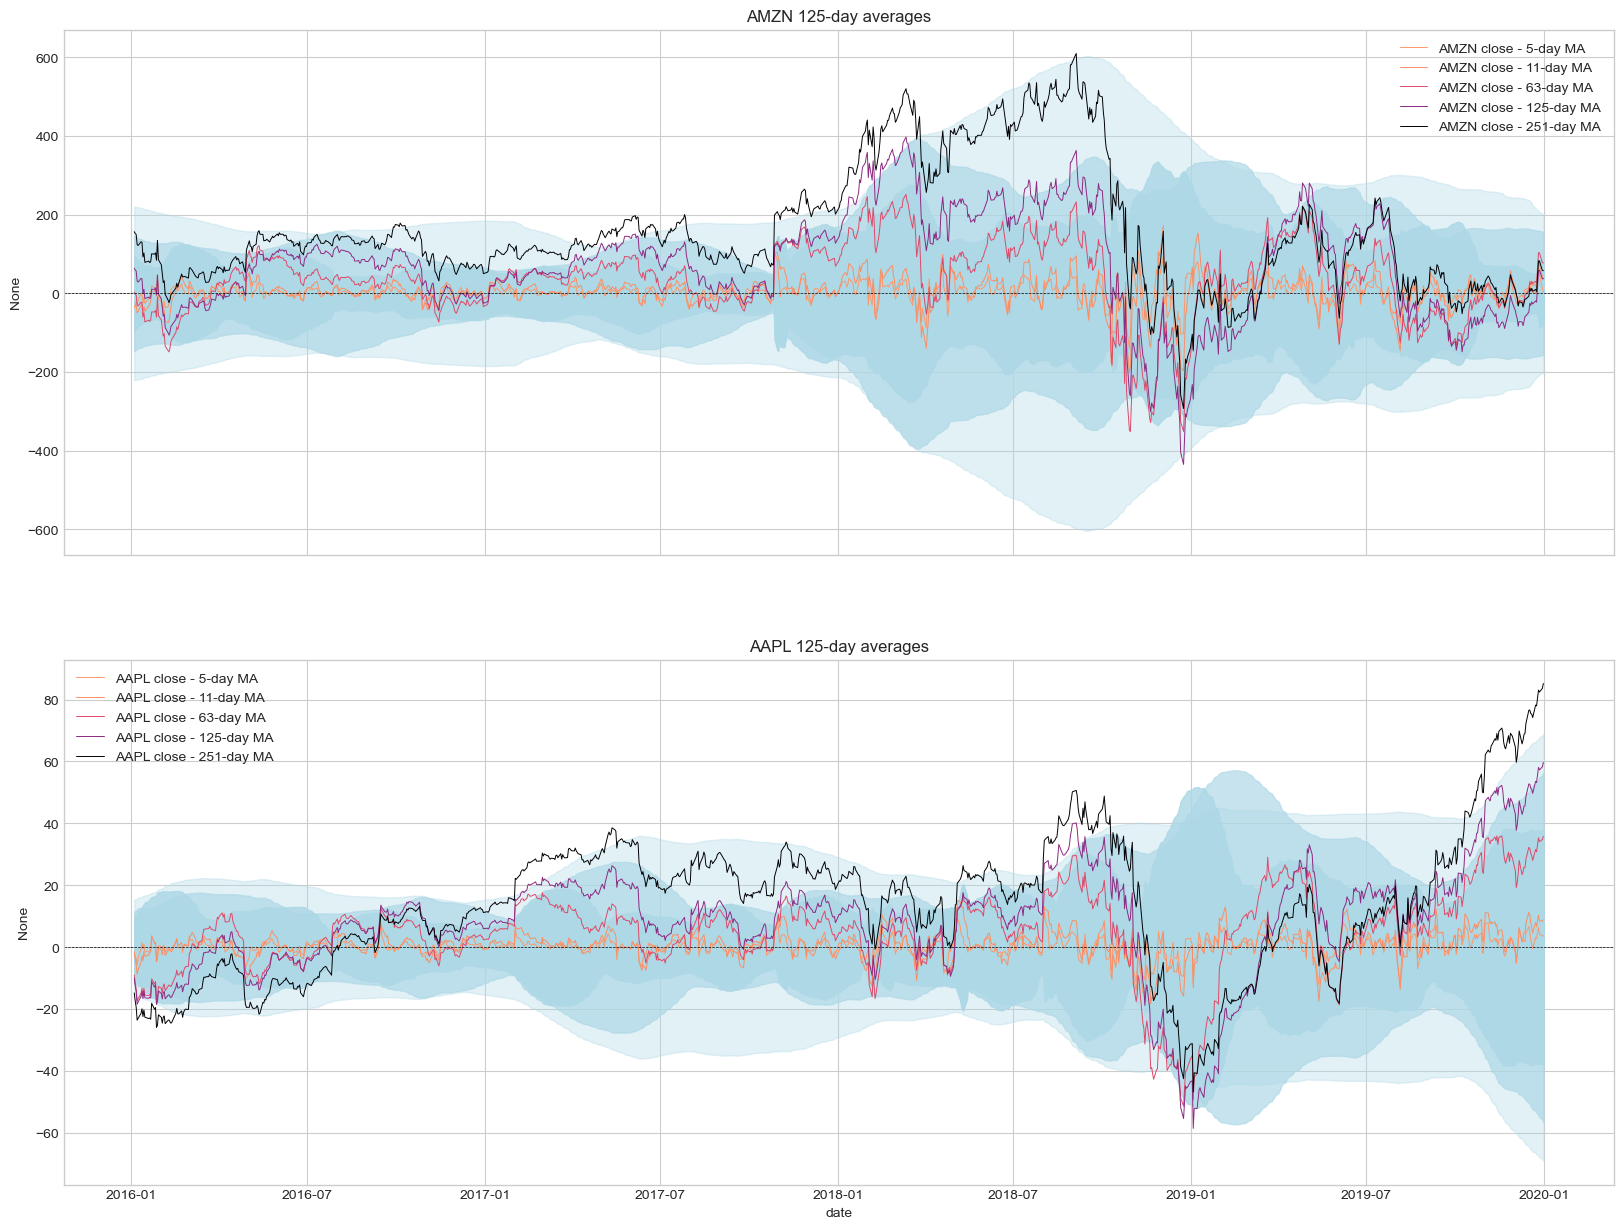

In [114]:
fig, axs = plt.subplots(2,1,figsize=(20,15),sharex=True)
for i, t in enumerate(['AMZN','AAPL']):
    df = stocks[t]
    df = df[df.index.year.isin([2016,2017,2018,2019,2019])]
    for w in [5,11,63,125,251]:
        sns.lineplot(x=df.index, 
                     y=df['close'] - df[f'ma_{w}'],
                     color=plt.cm.magma_r(0.2 + 0.8*w/251),
                     label=f'{t} close - {w}-day MA',
                     linewidth=0.7,
                     ax=axs[i])
    # sns.lineplot(np.log(df['ma_251']),color='blue',label=f'{t} 125-day MA',linewidth=0.5,ax=axs[i])
        # sns.lineplot(x=df.index,
        #              y=df[f'vwap_{w}'] - df[f'ma_{w}'],
        #              color=plt.cm.viridis_r(w/251),
        #              label=f'{t} {w}-day VWAP - {w}-day MA',
        #              linewidth=0.5,
        #              ax=axs[i])
        axs[i].fill_between(df.index,
                            y1= (df[f'bbu_{w}']) - (df[f'ma_{w}']), 
                            y2 = (df[f'bbl_{w}']) - (df[f'ma_{w}']), 
                            color='lightblue', 
                            alpha=1 - 0.65*w/251)
    # axs[i].fill_between(stocks[t].index, stocks[t]['bbu_21'], stocks[t]['bbl_21'], color='lightblue', alpha=0.5)
    # axs[i].fill_between(stocks[t]['bbu_21'],stocks[t]['bbl_21'],color='lightblue',alpha=0.5)
    # axs[1].fill_between(stocks[t]['vwbbu_21'],stocks[t]['vwbbl_21'],color='pink',alpha=0.5)
    axs[i].axhline(0,linestyle='--',linewidth=0.5,color='black')
    axs[i].set_title(f'{t} 125-day averages')
    axs[i].legend()
plt.plot()

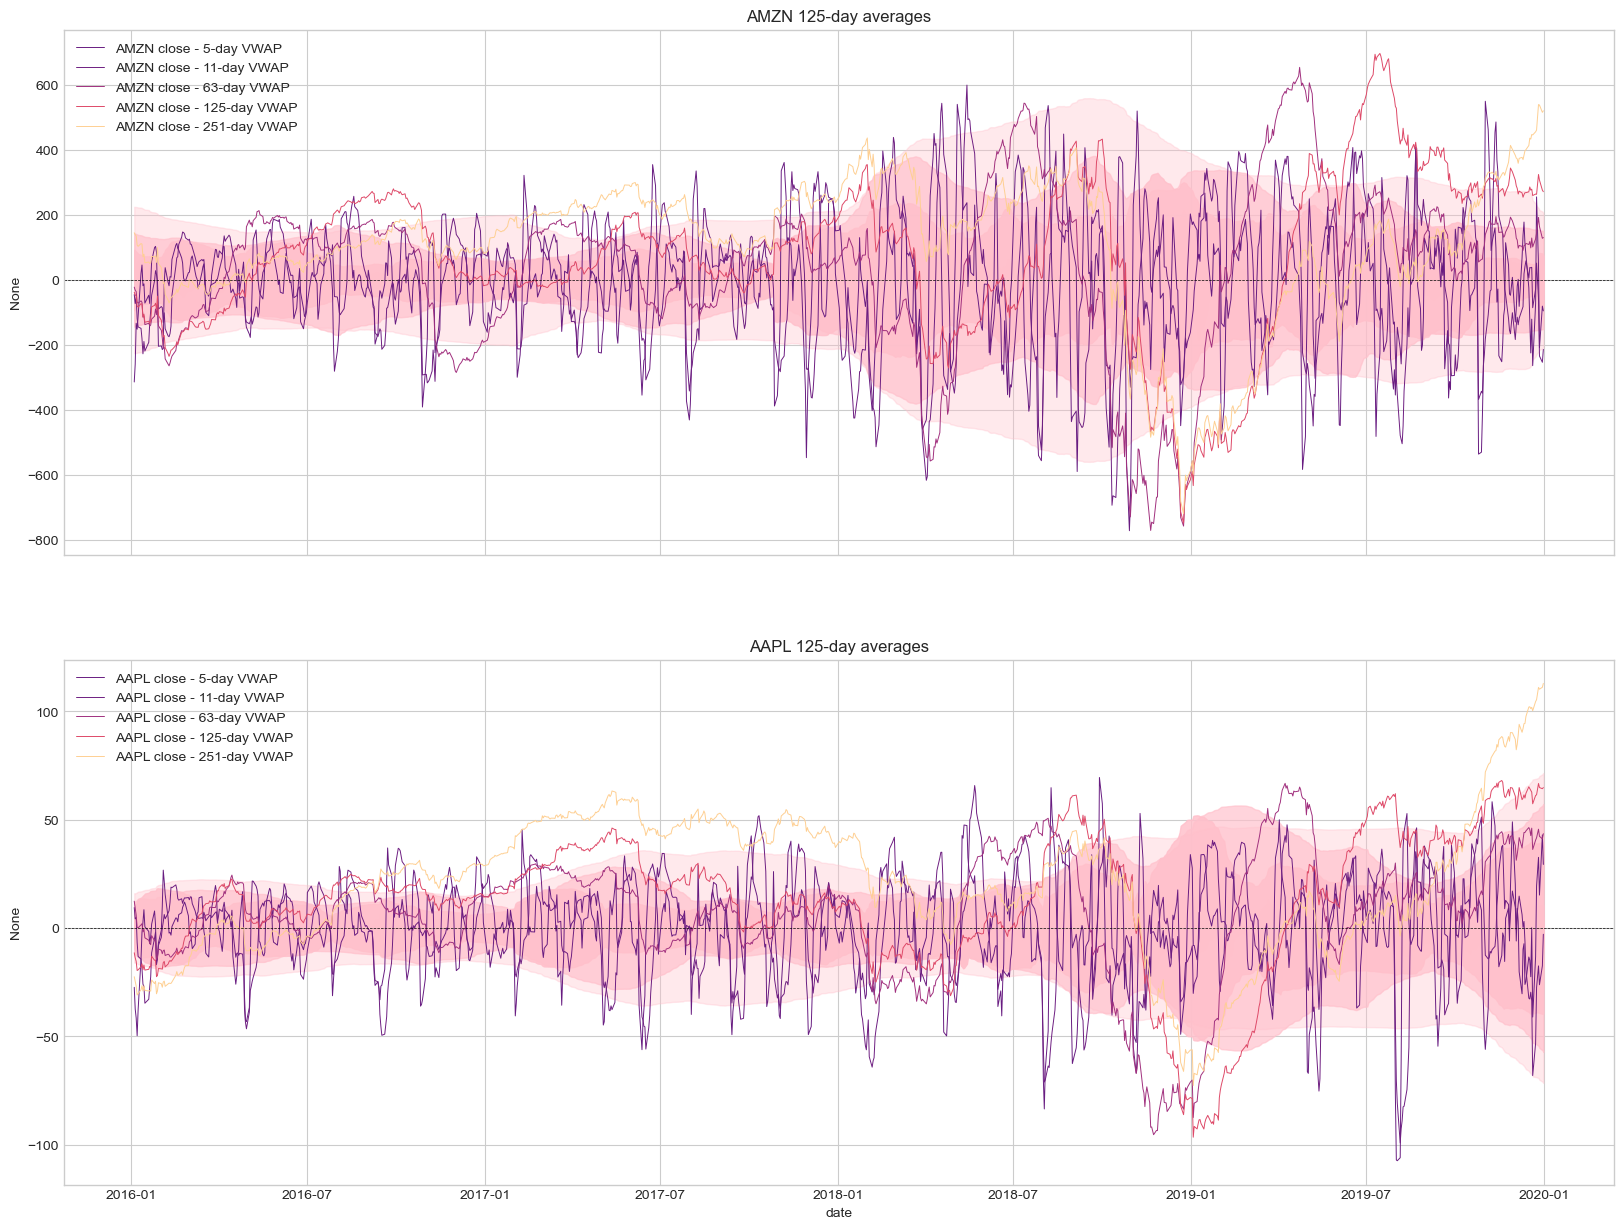

In [113]:
#plot exactly like the previous cell, but for the volume-weighted moving averages
fig, axs = plt.subplots(2,1,figsize=(20,15),sharex=True)
for i, t in enumerate(['AMZN','AAPL']):
    df = stocks[t]
    df = df[df.index.year.isin([2016,2017,2018,2019,2019])]
    for w in [5,11,63,125,251]:
        sns.lineplot(x=df.index, 
                     y=df['close'] - df[f'vwap_{w}'],
                     color=plt.cm.magma(0.3 + 0.6*w/251),
                     label=f'{t} close - {w}-day VWAP',
                     linewidth=0.7,
                     ax=axs[i])
    # sns.lineplot(np.log(df['ma_251']),color='blue',label=f'{t} 125-day MA',linewidth=0.5,ax=axs[i])
        # sns.lineplot(x=df.index,
        #              y=df[f'vwap_{w}'] - df[f'ma_{w}'],
        #              color=plt.cm.viridis_r(w/251),
        #              label=f'{t} {w}-day VWAP - {w}-day MA',
        #              linewidth=0.5,
        #              ax=axs[i])
        axs[i].fill_between(df.index,
                            y1= (df[f'vwbbu_{w}']) - (df[f'vwap_{w}']), 
                            y2 = (df[f'vwbbl_{w}']) - (df[f'vwap_{w}']), 
                            color='pink', 
                            alpha=1 - 0.65*w/251)
    # axs[i].fill_between(stocks[t].index, stocks[t]['bbu_21'], stocks[t]['bbl_21'], color='lightblue', alpha=0.5)
    # axs[i].fill_between(stocks[t]['bbu_21'],stocks[t]['bbl_21'],color='lightblue',alpha=0.5)
    # axs[1].fill_between(stocks[t]['vwbbu_21'],stocks[t]['vwbbl_21'],color='pink',alpha=0.5)
    axs[i].axhline(0,linestyle='--',linewidth=0.5,color='black')
    axs[i].set_title(f'{t} 125-day averages')
    axs[i].legend()